# Self-Driving Car Engineer Nanodegree
## Project 1: Finding Lane Lines on the Road
***

In this project, we are trying to identify and mark the lane lines on the road. We first identify it on a image and later employ the same functions to use it in a video stream. Primarily we will be using Python and OpenCV for this project. The steps involved can be broadly classified into few major steps/techniques. 

The following steps/techniques are used:
1. Identifying the best color space & Filtering out the required Color
2. Canny Edge Detection on Gray scaled & smoothed images
3. Region of Interest Selection via Masks
4. Using Hough Transform for Line Detection
5. Fine tuning via Averaging and Extrapolating Lines
6. Visual verification
7. Processing Video streams and final output


## 1- Identifying the best color space

Load the required libraries. Apart from the standard libraries (matplot, os, glob and numpy), we would be using the following:

- `cv2` for OpenCV
- `moviepy` for Video conversion

In [1]:
import cv2
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Helper function `show_image(s) for single/multiple images` used to display images.

In [2]:
def show_image(image, cmap=None):
    """Displays a single image"""
    cmap = 'gray' if len(image.shape)==2 else cmap
    plt.imshow(image, cmap=cmap)
    plt.show()

def show_images(images, cols = 2, cmap=None, figsize=(10, 11)):
    '''Displays a list of images'''
    rows = (len(images)+1)//cols
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

Load the test images for a visual inspection.

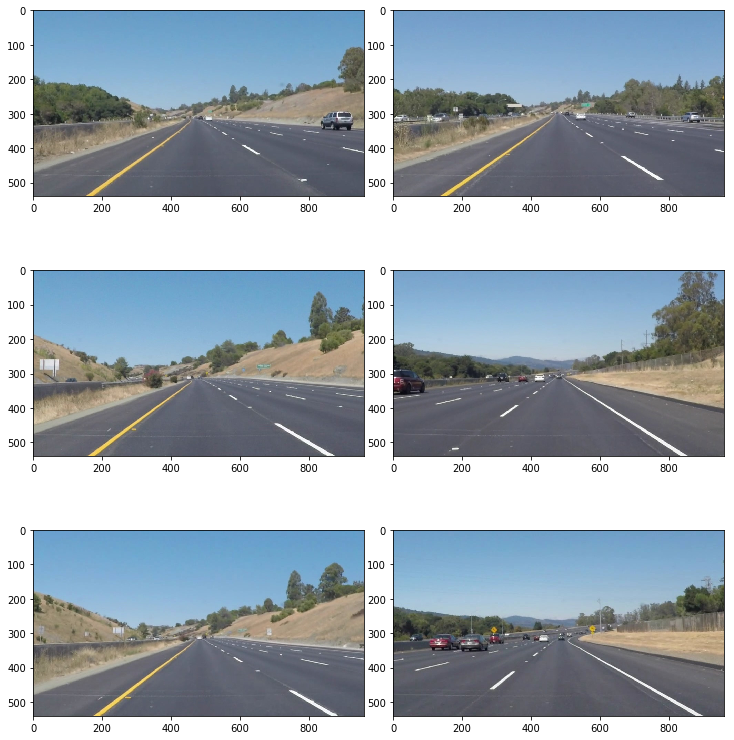

In [3]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)
#show_image(test_images[0])

Observation: 
The Lane Lines to be detected are either in white or yellow. We also have lines which are not continous.
All of these has to be marked as continous lines by our program.

### Identifying the best Color Space

By default we load the images that have been provided to us in RGB color space. We need to verify if RGB is good enough to detect the white and yellow lanes

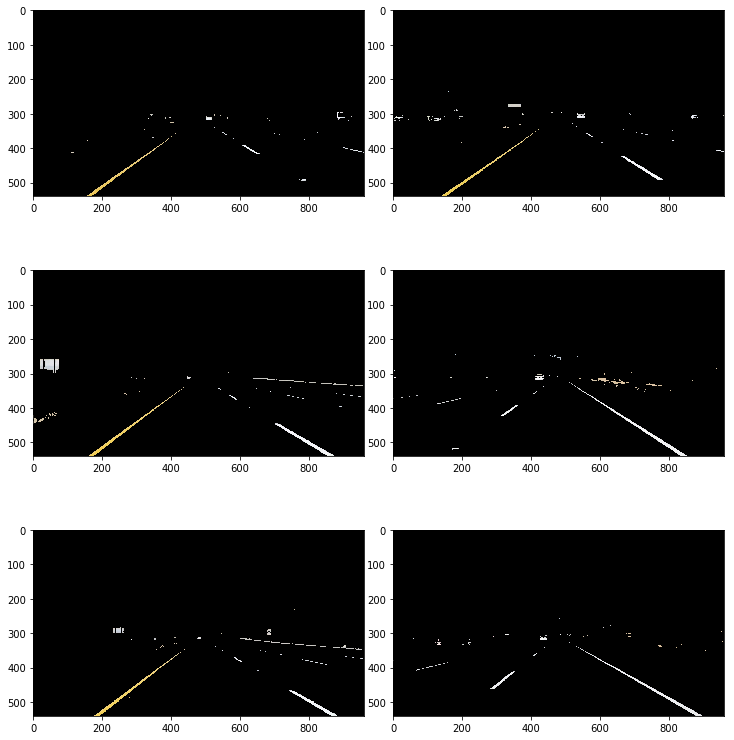

In [4]:
def detect_white_yellow_for_rgb(image):
    '''Detect/Filter White & Yellow in a RGB image'''
    # create a white color mask using range RGB[200,200,200 to 255,255,255]
    l_thresh = np.uint8([200, 200, 200])
    u_thresh = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, l_thresh, u_thresh)
    # create a yellow color mask using range RGB[190,190,0 to 255,255,255]
    l_thresh = np.uint8([190, 190,   0])
    u_thresh = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, l_thresh, u_thresh)
    # combine both the masks into a single mask. This will allow for either white or yellow range
    comb_mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_img = cv2.bitwise_and(image, image, mask = comb_mask)
    return masked_img

show_images(list(map(detect_white_yellow_for_rgb, test_images)))
#show_image(detect_white_yellow_for_rgb(test_images[0]))

This looks good, but we shall still see how things are in other Color Spaces (HSV & HSL)

#### HSV Color Space

Let us first see the images in HSV color space.

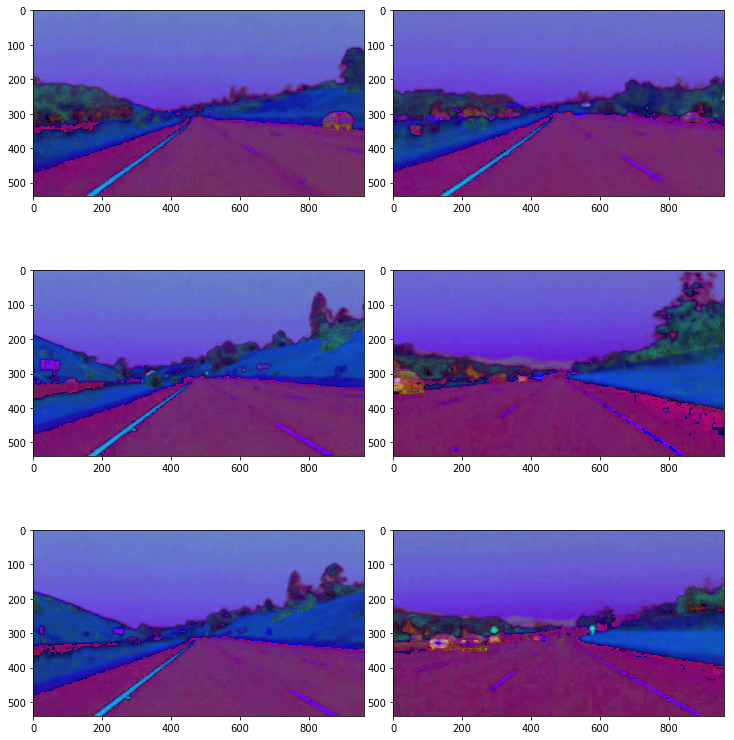

In [5]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_to_hsv, test_images)))
# show_image(convert_to_hsv(test_images[0]))

Yellow lines looks good, but not so the white lanes.

#### HSL Color Space

Let us now see the images in HSL color space.

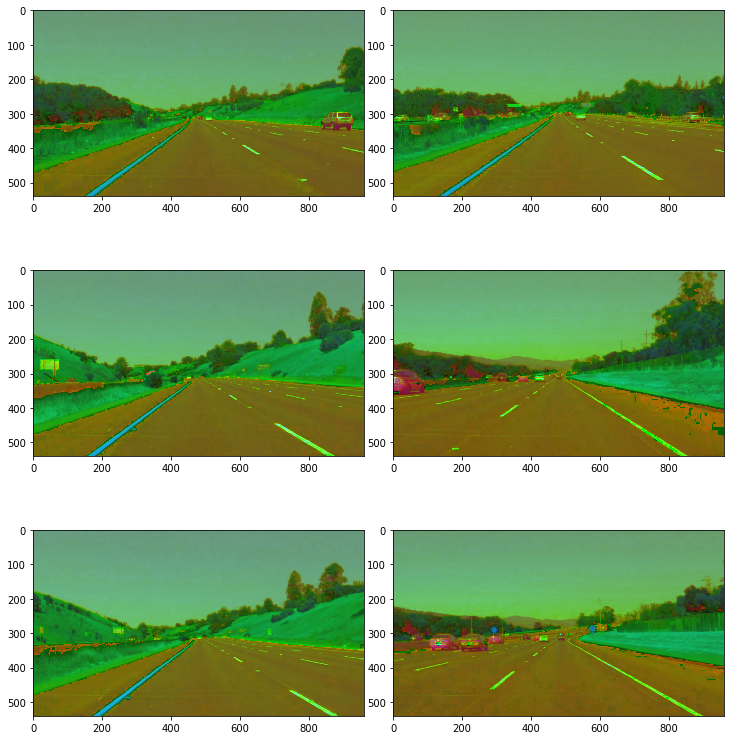

In [6]:
def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_to_hls, test_images)))
# show_image(convert_to_hls(test_images[0]))

Here both the white and yellow lines looks good. 

Let us filter out the white and yellow lines from the HSL format.
We should fine tune the particular range of each channels (Hue, Saturation and Light) repeatedly.
- For the white color, used a high **Light** value and no filters for **Hue**, **Saturation** values.
- For the yellow color, used a **Hue** of 30 and a high **Saturation**.

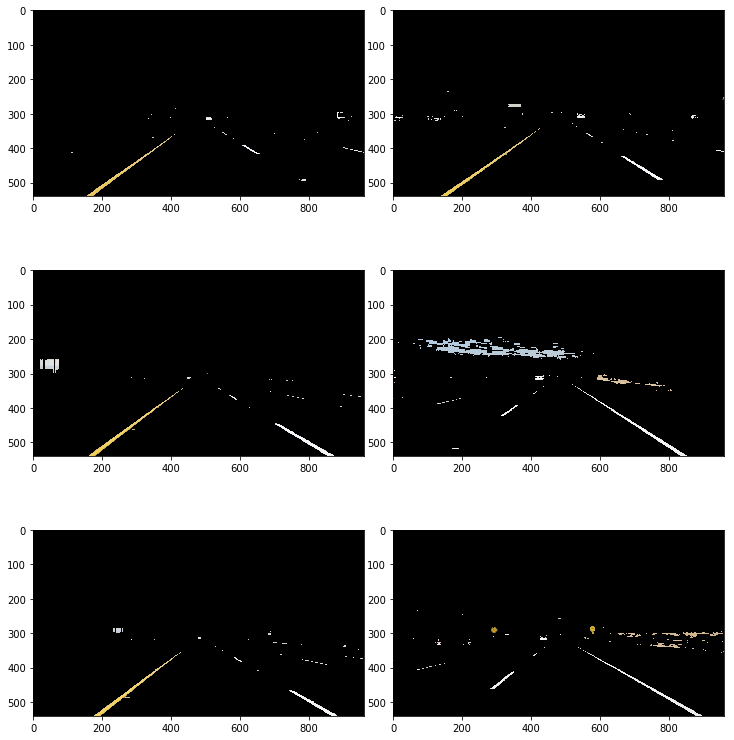

In [7]:
def detect_white_yellow_for_hsl(image):
    '''Detect/Filter White & Yellow in a HSL image'''
    converted = convert_to_hls(image)
    # create a white color mask using range HSL[0,200,0 to 255,255,255]
    l_thresh = np.uint8([  0, 200,   0])
    u_thresh = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, l_thresh, u_thresh)
    # create a white color mask using range HSL[10,0,100 to 40,255,255]
    l_thresh = np.uint8([ 10,   0, 100])
    u_thresh = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, l_thresh, u_thresh)
    # combine both the masks into a single mask. This will allow for either white or yellow range
    comb_mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_img = cv2.bitwise_and(image, image, mask = comb_mask)
    return masked_img

white_yellow_images = list(map(detect_white_yellow_for_hsl, test_images))
# white_yellow_image = detect_white_yellow_for_hsl(test_images[0])
show_images(white_yellow_images)
# show_image(white_yellow_image)

## 2- Canny Edge Detection on Gray scaled & smoothed images

We use the techinique of Canny Edge Detection to detect edges in the images (in effect the major shapes in the image). This works better when the image is GRAY scaled and SMOOTHED in order remove unwanted noice.

### Gray Scaling

Before using Canny Edge detection, we shall convert the images to GRAY scale as it helps to identify the shapes/edges better (better pixel intensity difference).

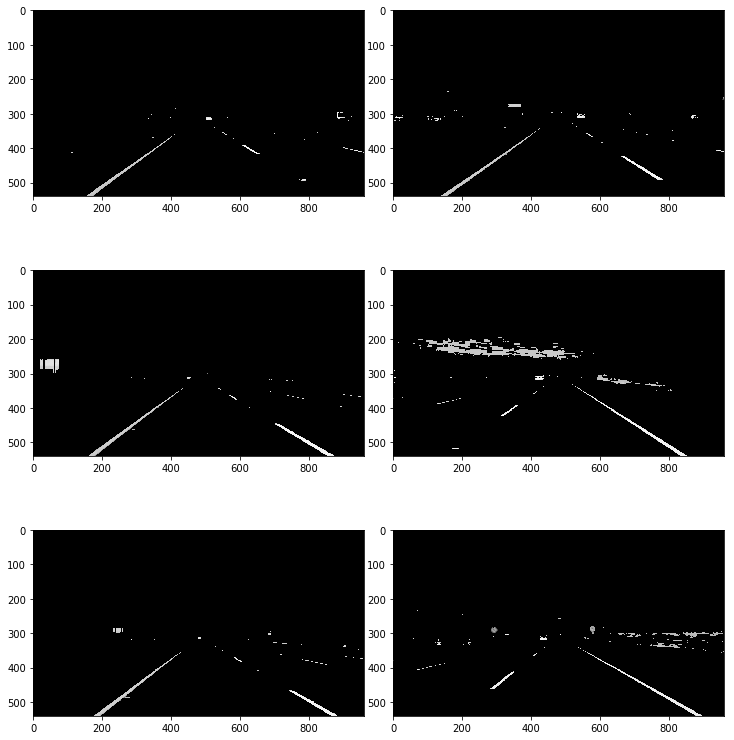

In [8]:
def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_to_gray, white_yellow_images))
# gray_image = convert_to_gray(white_yellow_image)
show_images(gray_images)
# show_image(gray_image)

### Smoothing using Gaussian Blur.

Edges are detected by identifying the rapid change of pixel intensity. But as you can see above, there is certain noice factor in the images due to rough edges which impacts the detection of lines. So we smooth out the edges before trying to detect them. The value of the kernel-size determines the size of matrix used to smooth (this should be a positive and odd number). A small number will retain the sharpness and a large number will make it blur. Fine-tune and find a good value.

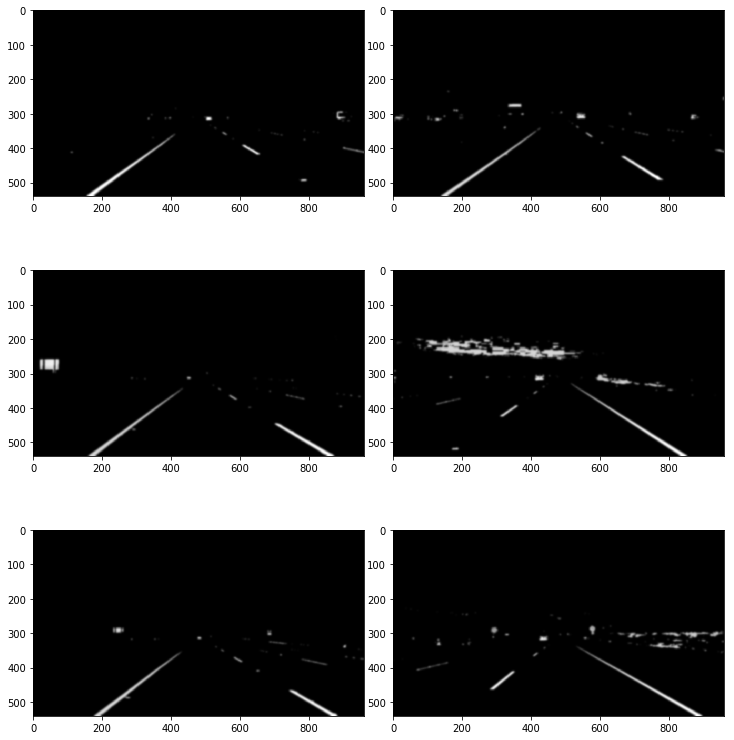

In [9]:
def smooth_by_blur(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

smoothed_images = list(map(lambda image: smooth_by_blur(image), gray_images))
# smoothed_image = smooth_by_blur(gray_image)
show_images(smoothed_images)
# show_image(smoothed_image)

### Edge Detection

Points to consider for Edge Detection:

We would be using two parms - lower-threshold & upper-threshold. The values are selected based on the below criterias.
- Pixel gradient higher than the upper threshold are retained
- Pixel gradient lower than the lower threshold are rejected.
- Pixel gradient is between the two thresholds are accepted only if it is connected to a pixel that is above the upper threshold.

Use trial and error to identify the values here which will retain the required edges and remove the noice.

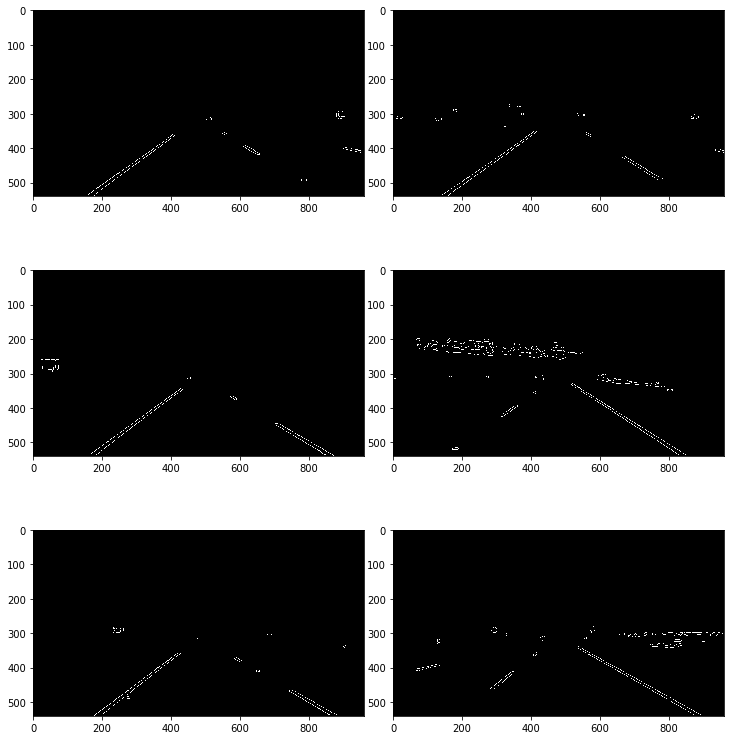

In [10]:
def detect_edges(image, l_thresh=50, h_thresh=150):
    return cv2.Canny(image, l_thresh, h_thresh)

edge_images = list(map(lambda image: detect_edges(image), smoothed_images))
# edge_image = detect_edges(smoothed_image)
show_images(edge_images)
# show_image(edge_image)

## 3- Region of Interest Selection via Masks

We shall focus our attention to a polygon shape where we expect to find the lane lines and ignore the remaining areas in the image (like other lanes, sky, hills). We do this basically by applying a mask.

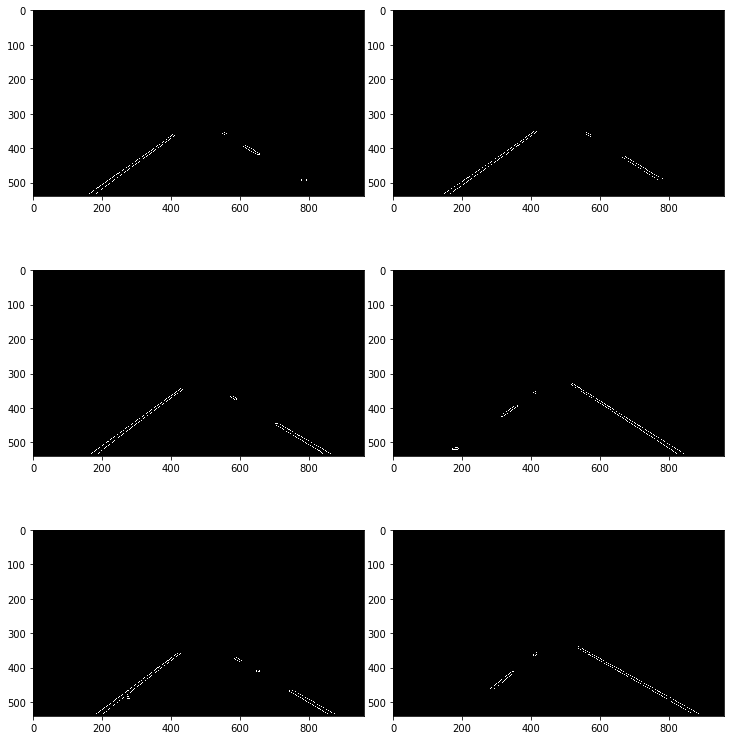

In [11]:
def mask_select_region(image):
    """
    Define the polygon by identifying the four vertices.
    Define the mask color (black) and shape (based on channels) 
    Except for the region bounded by the vertices, other area is set to black(0).
    """
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.05, rows*0.99]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.95, rows*0.99]
    top_right    = [cols*0.6, rows*0.6] 
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        ignore_mask_color = 255
    else:
        ignore_mask_color = (255,) * mask.shape[2]        

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

masked_images = list(map(mask_select_region, edge_images))
# masked_image = mask_select_region(edge_image)

show_images(masked_images)
# show_image(masked_image)

## 4- Using Hough Transform for Line Detection

We use Hough transform to identify lines in the edge images. There are multiple parameters to be defined here.

`rho` and `theta` are the Hough Space parameters

`threshold` is the minimum votes required for the selected lines

`min line length` is the minimum length of the line segment to be accepted

`max line gap` is the max value for the gap allowed between points on single line 

Please refer `cv2.HoughLinesP` in opencv documentation for more details.

In [12]:
def hough_lines(image):
    """
    Uses the edge-image as input and produces the hough-lines as output
    rho=1
    theta=np.pi/180
    threshold=20
    minLineLength=20
    maxLineGap=300
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

list_of_lines = list(map(hough_lines, masked_images))
# list_of_line = hough_lines(roi_image)


Draw the lines onto the original images.  

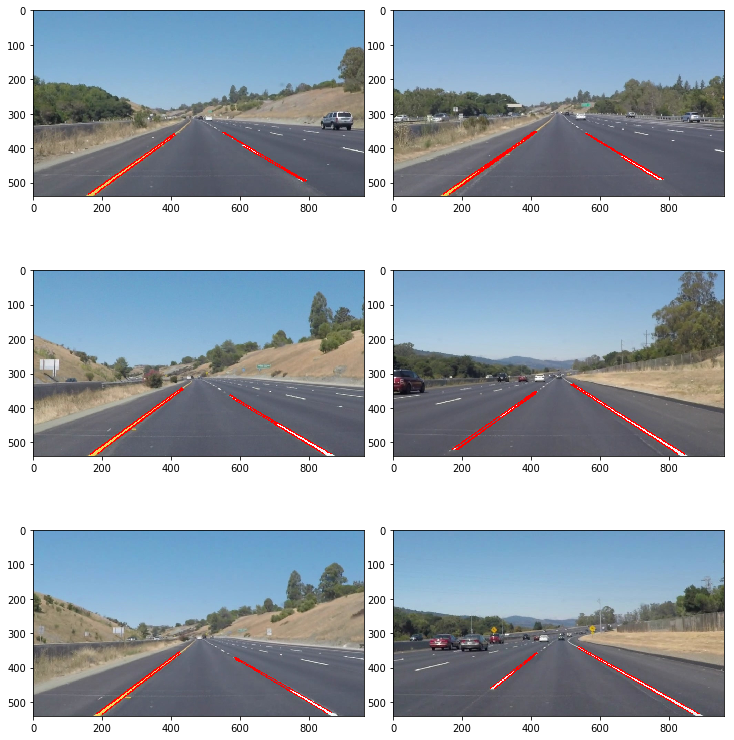

In [13]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

# line_image = draw_lines(test_images[0], list_of_line)
show_images(line_images)
# show_image(line_image)

### 5- Fine tuning via Averaging and Extrapolating Lines

In the process of fine-tuning the detected lines, the multiple lines detected for a lane line should be averaged to a single line and where ever the lines are partially recognized, it should extrapolated to make it a full lane line.

Additionally, classify the lane line as left/right based on teh slope of the line. Normally the left lane comes with positive slope, but in the image y-coordinate is from top-to-bottom, hence left lane has a negative slope and right-lane has positive slope.

In [14]:
def average_lines_to_lane(lines):
    '''
    Accumulate the left and right lines (in slope/intercept form) and their weights (length)
    Deciding whether left/right lane is based on the slope
    More weight is added to longer lines    
    Output is the average slope and intercept for the left and right lanes of each image.
    '''

    left_lines = []
    right_lines = []
    left_wts = []
    right_wts = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore the vertical lines, slope in INF
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # neg-slope is left-lane since y is reversed in image
                left_lines.append((slope, intercept))
                left_wts.append((length))
            else: # pos-slope is right-lane since y is reversed in image
                right_lines.append((slope, intercept))
                right_wts.append((length))

    # Defined as dot product of weights & lines divided by weights
    if len(left_wts) >0:
        left_lane  = np.dot(left_wts,  left_lines) /np.sum(left_wts)
    else:
        left_lane  = None
    if len(right_wts)>0:
        right_lane = np.dot(right_wts, right_lines)/np.sum(right_wts)
    else:
        right_lane = None
    
    return left_lane, right_lane

We would need the x-y coordinates (in pixel points) to draw the lanes. This will be derived from the slope and intercept.

In [15]:
def slopeint_to_xy_points(y1, y2, line):
    """
    Input: y coordinates along with the slope and intercept
    Output: x-y coordinates (in pixel points) of the line segment
    """
    if line is None:
        return None
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [16]:
def get_final_leftright_lines(image, lines):
    """
    image - on which the lane to be drawn
    lines - all lines identified
    Find the average line for left and right and return in xy coordinate form
    """
    llane, rlane = average_lines_to_lane(lines)
    
    # We need to decide the start and end of the lane-lines that we are drawing
    # We shall start from the bottom of the image and draw till somewhere a little less than the middle of image.
    y1 = image.shape[0]
    y2 = y1*0.6

    l_line  = slopeint_to_xy_points(y1, y2, llane)
    r_line = slopeint_to_xy_points(y1, y2, rlane)
    
    return l_line, r_line

In [17]:
def draw_lane_on_image(image, lines, color=[255, 0, 0], thickness=10):
    """
    image - on which the lane to be drawn
    lines - x and y points of the line to be drawn (x1, y1), (x2, y2)
    color - red [255,0,0]
    thickness - 10
    """

    l_image = np.zeros_like(image) # copy the image
    for line in lines:
        if line is not None:
            cv2.line(l_image, *line,  color, thickness)
            
    # returns the weighted sum of two images
    # src1*alpha + src2*beta + gamma
    return cv2.addWeighted(image, 1.0, l_image, 0.95, 0.0)

## 6- Visual verification

Let us pull all things together and see how our final image would be. 

Input will be the images and list-of-lines (from hough lines)


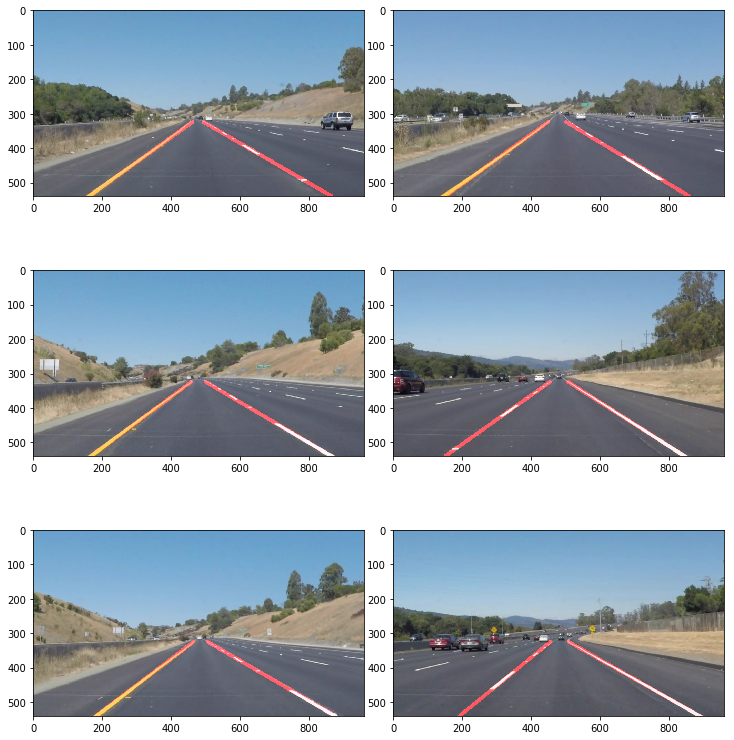

In [18]:
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_on_image(image, get_final_leftright_lines(image, lines)))

# lane_image = draw_lane_on_image(test_images[0], get_final_leftright_lines(test_images[0], list_of_line))
show_images(lane_images)
# show_image(lane_image)

## 7- Processing Video streams and final output

Create a class (FindingLanes) which would include all your pipeline steps.

We will use this to process our video clips.

In [19]:
from collections import deque

QUEUE_LENGTH=50

class FindingLanes:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process_img(self, image):
        wy_hsl = detect_white_yellow_for_hsl(image)
        gray = convert_to_gray(wy_hsl)
        smoothed_gray = smooth_by_blur(gray)
        edges = detect_edges(smoothed_gray)
        regions = mask_select_region(edges)
        h_lines = hough_lines(regions)
        left_line, right_line = get_final_leftright_lines(image, h_lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line))
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return draw_lane_on_image(image, (left_line, right_line))

In [20]:
def lane_in_video(v_in, v_out):
    lanefinder = FindingLanes()
    in_path = os.path.join('test_videos', v_in)
    out_path = os.path.join('test_videos_output', v_out)
    v_clip = VideoFileClip(in_path)
    processed = v_clip.fl_image(lanefinder.process_img)
    processed.write_videofile(out_path, audio=False)

**Let's try the one with the solid white lane on the right first ...**
All outputs are available in the 'test_videos_output' folder

In [21]:
lane_in_video('solidWhiteRight.mp4', 'solidWhiteRight_out.mp4')    

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_out.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_out.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_out.mp4 



In [22]:
lane_in_video('solidYellowLeft.mp4', 'solidYellowLeft_out.mp4')

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_out.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_out.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_out.mp4 



In [23]:
lane_in_video('challenge.mp4', 'challenge_out.mp4')

[MoviePy] >>>> Building video test_videos_output/challenge_out.mp4
[MoviePy] Writing video test_videos_output/challenge_out.mp4


100%|██████████| 251/251 [00:15<00:00, 16.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_out.mp4 



This concludes the project.
Thank you.